In [208]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [223]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary
special_tokens = ['.'] # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')

# mapping from chars to token number and vice-versa
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = vocab
encode = lambda char_seq: [ctoi[c] for c in char_seq]
decode = lambda token_num_seq: [itoc[t] for t in token_num_seq]
print(encode("vlad"), decode([22,12,1,4]))

# prepare dataset for NN training and validation
block_size = 3 # represents the length of context
def build_dataset(names):
    X, y = [], []
    for name in names:
        block = torch.zeros(block_size).to(torch.int64)
        for c in name + '.':
            ix = ctoi[c]
            X.append(block)
            y.append(ix)
            block = block.roll(-1)
            block[-1] = ix
    X, y = torch.stack(X), torch.tensor(y)
    return X, y

#train/validation/test split
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_dataset(names[:train_bound])
val_X, val_y = build_dataset(names[train_bound:val_bound])
test_X, test_y = build_dataset(names[val_bound:])
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(decode(train_X[i]))} => {itoc[train_y[i]]}')
print("val:")
for i in range(13):
    print(f'{"".join(decode(val_X[i]))} => {itoc[val_y[i]]}')
print("test:")
for i in range(13):
    print(f'{"".join(decode(test_X[i]))} => {itoc[test_y[i]]}')

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
X.shape=torch.Size([182681, 3]), y.shape=torch.Size([182681])
X.shape=torch.Size([22589, 3]), y.shape=torch.Size([22589])
X.shape=torch.Size([22876, 3]), y.shape=torch.Size([22876])
train_X.shape=torch.Size([182681, 3]), train_y.shape=torch.Size([182681]), val_X.shape=torch.Size([22589, 3]), val_y.shape=torch.Size([22589]), test_X.shape=torch.Size([22876, 3]), test_y.shape=torch.Size([22876])
train:
... => j
..j => e
.je => i
jei => l
eil => y
ily => n
lyn => .
... => r
..r => y
.ry => z
ryz => e
yze => .
... => k
val:
... => i
..i => s
.is => h
ish => m
shm => a
hma => e
mae => l
ael => .
... => a
..a => d
.ad => r
adr => i
dri => e
test:
... => k
..k => r
.kr => o
kro => s
ros => s
oss => .
... => c
..c => l
.cl => a
cla => r
lar =>

### Define training loop and Evaluation method

In [278]:
def train(model, train_X, train_y, val_X, val_y, epoches, batch_size, lr=1e-3):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        ids = torch.randperm(train_X.shape[0])
        cur_losses = []
        for batch_ids_lb in range(0, train_X.shape[0], batch_size):
            batch_ids = ids[batch_ids_lb:batch_ids_lb+batch_size]
            mini_batch_X = train_X[batch_ids].to(device)
            mini_batch_y = train_y[batch_ids].to(device)
            logits = model(mini_batch_X)
            loss = F.cross_entropy(logits, mini_batch_y)
            cur_losses.append(loss.item())
            model.zero_grad()
            loss.backward()
            model.optimize(lr = lr)
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_X), val_y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss


@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

In [246]:
class MLP:
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, device='cpu'):
        self.context_size = block_size*emb_size
        self.emb = torch.randn((vocab_size, emb_size), requires_grad = True, device = device)
        self.W1 = torch.randn((self.context_size, hidden_size), requires_grad = True, device = device)
        self.b1 = torch.randn(hidden_size, requires_grad = True, device = device)
        self.W2 = torch.randn((hidden_size, vocab_size), requires_grad = True, device = device)
        self.b2 = torch.randn(vocab_size, requires_grad = True, device = device)
    
    def forward(self, mini_batch_X):
        embeddings  = self.emb[mini_batch_X]
        concat_embs = embeddings.view(-1, self.context_size)
        out1 = concat_embs @ self.W1 + self.b1
        out1 = F.tanh(out1)
        out2 = out1 @ self.W2 + self.b2
        return out2

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def optimize(self, lr):
        for p in self.parameters():
            p.data -= lr*p.grad

    def parameters(self):
        return [self.emb, self.W1, self.b1, self.W2, self.b2]

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def __call__(self, mini_batch_X):
        return self.forward(mini_batch_X)

model.nelement()=4433
epoch=0: cur_avg_train_loss=2.7666857048007945, cur_val_loss=2.7125062942504883
epoch=1: cur_avg_train_loss=2.5164856500675716, cur_val_loss=2.525550603866577
epoch=2: cur_avg_train_loss=2.4825586249239597, cur_val_loss=2.4961893558502197
epoch=3: cur_avg_train_loss=2.457539295983189, cur_val_loss=2.455648183822632
epoch=4: cur_avg_train_loss=2.4427207526726398, cur_val_loss=2.479430913925171
epoch=5: cur_avg_train_loss=2.4315096380414145, cur_val_loss=2.4662413597106934
epoch=6: cur_avg_train_loss=2.421716611731908, cur_val_loss=2.4478588104248047
epoch=7: cur_avg_train_loss=2.414546715231994, cur_val_loss=2.4781136512756348
epoch=8: cur_avg_train_loss=2.40948101572314, cur_val_loss=2.4799885749816895
epoch=9: cur_avg_train_loss=2.401956712343647, cur_val_loss=2.4142191410064697
epoch=10: cur_avg_train_loss=2.39661434648751, cur_val_loss=2.4618091583251953
epoch=11: cur_avg_train_loss=2.3904594021377963, cur_val_loss=2.4366424083709717
epoch=12: cur_avg_train_los

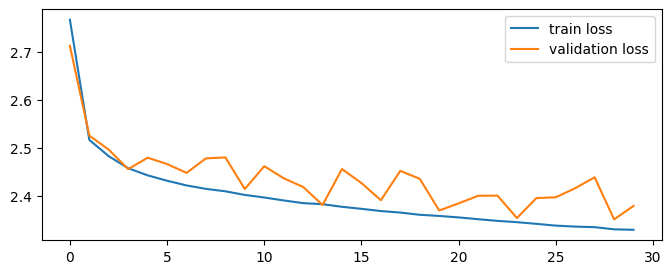

In [251]:
model = MLP(vocab_size, block_size, emb_size=2, hidden_size=128, device=device)
print(f'{model.nelement()=}')
train_loss, val_loss = train(model, train_X, train_y, val_X.to(device), val_y.to(device), epoches=30, batch_size=64, lr=0.1)
plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [253]:
for i in range(10):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

aly.
mirion.
brinjitk.
aubariya.
dyun.
son.
mrangh.
kee.
vau.
bloaz.


### Visualize 2D embeddings

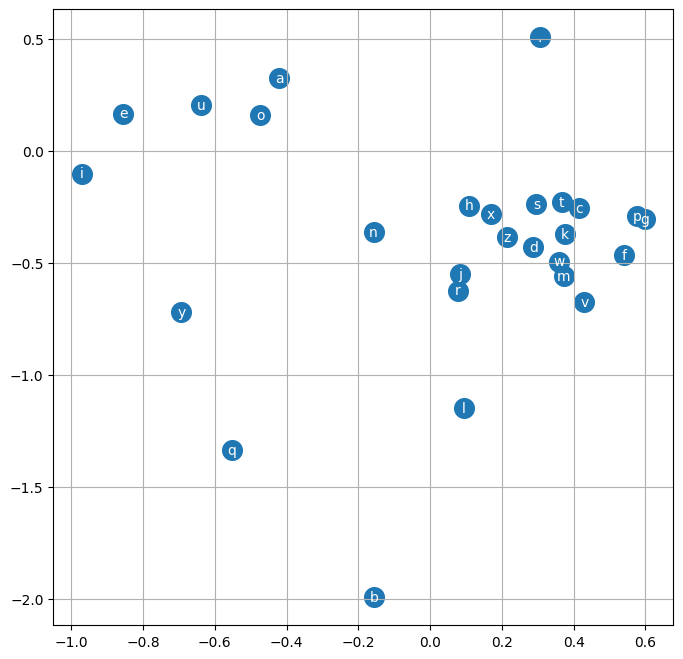

In [260]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Scale-up the model

model384.nelement()=22569
epoch=0: cur_avg_train_loss=4.537107204180048, cur_val_loss=3.3436193466186523
epoch=1: cur_avg_train_loss=2.8663437752297796, cur_val_loss=2.984354019165039
epoch=2: cur_avg_train_loss=2.697152230284469, cur_val_loss=3.1005892753601074
epoch=3: cur_avg_train_loss=2.6289448362724586, cur_val_loss=2.908522605895996
epoch=4: cur_avg_train_loss=2.5842694454560555, cur_val_loss=2.7352471351623535
epoch=5: cur_avg_train_loss=2.551323105491398, cur_val_loss=2.6226818561553955
epoch=6: cur_avg_train_loss=2.5272387639027345, cur_val_loss=2.7434778213500977
epoch=7: cur_avg_train_loss=2.507199018097592, cur_val_loss=2.6827163696289062
epoch=8: cur_avg_train_loss=2.492223301827386, cur_val_loss=2.7193729877471924
epoch=9: cur_avg_train_loss=2.4761044017905323, cur_val_loss=2.683624744415283
epoch=10: cur_avg_train_loss=2.4687238843553745, cur_val_loss=2.7304656505584717
epoch=11: cur_avg_train_loss=2.4529719223700557, cur_val_loss=2.709752082824707
epoch=12: cur_avg_tra

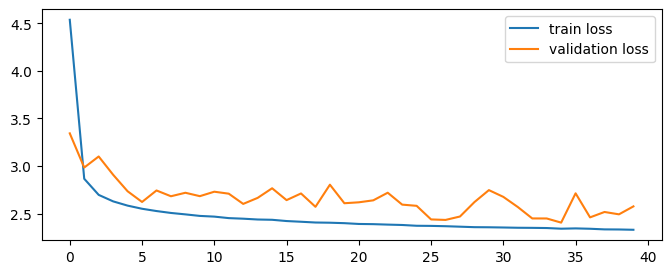

In [271]:
model384 = MLP(vocab_size, block_size, emb_size=10, hidden_size=384, device=device)
print(f'{model384.nelement()=}')
train_loss, val_loss = train(model384, train_X, train_y, val_X.to(device), val_y.to(device), epoches=40, batch_size=64, lr=0.1)

plt.figure(figsize=(8,3))
plt.plot(np.array(train_loss), label = 'train loss')
plt.plot(np.array(val_loss), label = 'validation loss')
plt.legend()

In [272]:
for i in range(10):
    print(''.join(decode(evaluate(model384, max_new_tokens=1000))))

bro.
cene.
dechennediaigenii.
kesia.
ebaishaureytani.
kenduadhariaei.
eddajiha.
keya.
charidenahishahiree.
jenevedyn.


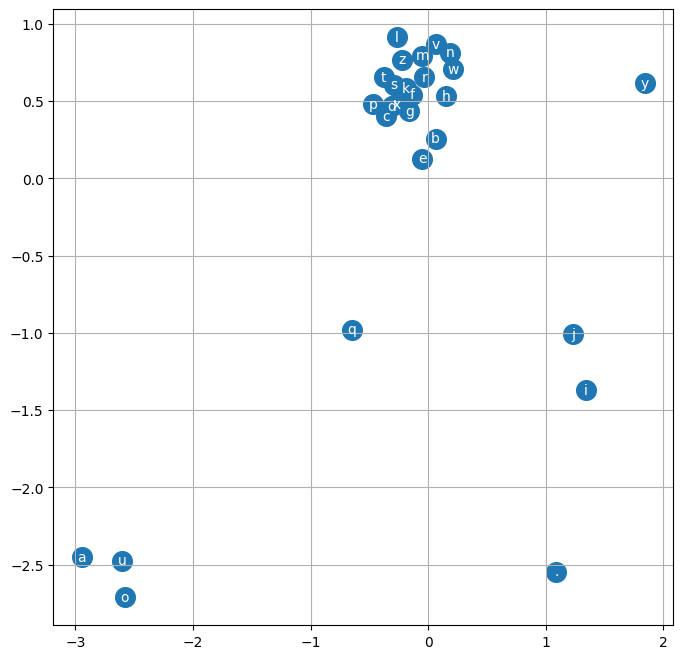

In [273]:
# visualize some 2 dimensions of the embedding matrix model384.emb for all characters
plt.figure(figsize=(8,8))
C = model384.emb.cpu()
dim1, dim2 = 4, 5
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Test evaluation

In [277]:
with torch.no_grad():
    test_logits = model384(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5710)
